This notebook provides examples to go along with the [textbook](https://underactuated.csail.mit.edu/trajopt.html).  I recommend having both windows open, side-by-side!


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pydrake.all import (AbstractValue, Cylinder, DiagramBuilder,
                         DirectCollocation,
                         FiniteHorizonLinearQuadraticRegulatorOptions,
                         FramePoseVector, LeafSystem, LeafSystem_,
                         LogVectorOutput,
                         MakeFiniteHorizonLinearQuadraticRegulator,
                         MeshcatVisualizer, MultibodyPlant, Parser,
                         PiecewisePolynomial, Rgba, RigidTransform,
                         RotationMatrix, SceneGraph, Simulator, Solve,
                         StartMeshcat, TemplateSystem, TrajectorySource,
                         namedview)

from underactuated import FindResource
from underactuated.scenarios import AddShape


In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at https://5981f1c9-7fa9-4b35-9496-bb0f15aac7ff.deepnoteproject.com/7000/
Installing NginX server for MeshCat on Deepnote...


In [3]:
GliderState = namedview(
    "GliderState", ["x", "z", "pitch", "elevator", "xdot", "zdot", "pitchdot"])

# Note: In order to use the Python system with drake's autodiff features, we
# have to add a little "TemplateSystem" boilerplate (for now).  For details,
# see https://drake.mit.edu/pydrake/pydrake.systems.scalar_conversion.html

@TemplateSystem.define("GliderPlant_")
def GliderPlant_(T):

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            # one inputs (elevator_velocity)
            self.DeclareVectorInputPort("elevatordot", 1)
            self.DeclareContinuousState(7)
            # seven outputs (full state)
            self.DeclareVectorOutputPort("state", 7, self.CopyStateOut)
            self.DeclareVectorOutputPort("forces", 2, self.OutputForces)

            # parameters based on Rick Cory's "R1 = no dihedral" model.
            self.Sw = 0.0885  # surface area of wing + fuselage + tail.
            self.Se = 0.0147  # surface area of elevator.
            self.lw = 0  # horizontal offset of wing center.
            self.le = 0.022  # elevator aerodynamic center from hinge.
            #self.lh = 0.317  # elevator hinge.
            self.lh = 0.27   # elevator hinge.
            self.inertia = 0.0015  # body inertia.
            self.m = 0.08  # body mass.
            self.rho = 1.204  # air density (kg/m^3).
            self.gravity = 9.81  # gravity

            # TODO(russt): Declare elevator constraints:
            self.elevator_lower_limit = -0.9473
            self.elevator_upper_limit = 0.4463

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def ComputeForces(self, context):
            s = GliderState(
                context.get_mutable_continuous_state_vector().CopyToVector())
            elevatordot = self.EvalVectorInput(context, 0)[0]

            eps = 1e-10
            xwdot = s.xdot + self.lw * s.pitchdot * np.sin(s.pitch)
            zwdot = s.zdot + self.lw * s.pitchdot * np.cos(s.pitch)
            vw = np.sqrt(zwdot**2 + xwdot**2 + eps)
            fw = -self.rho * self.Sw * (np.sin(s.pitch) * xwdot
                                        + np.cos(s.pitch) * zwdot) * vw

            e = s.pitch + s.elevator
            edot = s.pitchdot + elevatordot
            xedot = s.xdot + self.lh * s.pitchdot * np.sin(s.pitch) \
                + self.le * edot * np.sin(e)
            zedot = s.zdot + self.lh * s.pitchdot * np.cos(s.pitch) \
                + self.le * edot * np.cos(e)
            ve = np.sqrt(zedot**2 + xedot**2 + eps)
            fe = -self.rho * self.Se * (np.sin(e)*xedot + np.cos(e)*zedot)*ve

            return fw, fe


        def DoCalcTimeDerivatives(self, context, derivatives):
            s = GliderState(
                context.get_mutable_continuous_state_vector().CopyToVector())
            elevatordot = self.EvalVectorInput(context, 0)[0]
            e = s.pitch + s.elevator
            fw, fe = self.ComputeForces(context)

            sdot = GliderState(s[:])
            sdot[0:3] = s[4:7]
            sdot.elevator = elevatordot
            sdot.xdot = (fw * np.sin(s.pitch) + fe * np.sin(e)) / self.m
            sdot.zdot = (fw * np.cos(s.pitch) + fe * np.cos(e)) / self.m - self.gravity
            sdot.pitchdot = (fw * self.lw + fe * (self.lh * np.cos(s.elevator) + self.le)) / self.inertia
            derivatives.get_mutable_vector().SetFromVector(sdot[:])

        def CopyStateOut(self, context, output):
            x = context.get_continuous_state_vector().CopyToVector()
            output.SetFromVector(x)

        def OutputForces(self, context, output):
            fw, fe = self.ComputeForces(context)
            output.SetFromVector([fw, fe])


    return Impl

GliderPlant = GliderPlant_[None]  # Default instantiation


# To use glider.urdf for visualization, follow the pattern from e.g.
# drake::examples::quadrotor::QuadrotorGeometry.
class GliderGeometry(LeafSystem):

    def __init__(self, scene_graph):
        LeafSystem.__init__(self)
        assert scene_graph

        mbp = MultibodyPlant(1.0)  # Timestep doesn't matter, and this avoids a warning
        parser = Parser(mbp, scene_graph)
        model_id = parser.AddModelFromFile(
            FindResource("models/glider/glider.urdf"))

        perch_id = AddShape(mbp, Cylinder(0.02, 2.0), "perch")
        self.X_perch_ = RigidTransform(RotationMatrix.MakeXRotation(np.pi/2.0))
        mbp.WeldFrames(mbp.world_frame(), mbp.GetFrameByName("perch"),
                       self.X_perch_)

        mbp.Finalize()
        self.source_id = mbp.get_source_id()
        self.body_frame_id = mbp.GetBodyFrameIdOrThrow(
            mbp.GetBodyIndices(model_id)[0])
        self.elevator_frame_id = mbp.GetBodyFrameIdOrThrow(
            mbp.GetBodyIndices(model_id)[1])
        self.perch_frame_id = mbp.GetBodyFrameIdOrThrow(
            mbp.GetBodyIndices(perch_id)[0])

        self.DeclareVectorInputPort("state", 7)
        self.DeclareAbstractOutputPort(
            "geometry_pose", lambda: AbstractValue.Make(FramePoseVector()),
            self.OutputGeometryPose)

    def OutputGeometryPose(self, context, poses):
        assert self.body_frame_id.is_valid()
        assert self.elevator_frame_id.is_valid()
        lh = 0.317  # elevator hinge.
        state = GliderState(self.get_input_port(0).Eval(context))
        body_pose = RigidTransform(RotationMatrix.MakeYRotation(state.pitch),
                                   [state.x, 0, state.z])
        elevator_pose = RigidTransform(
            RotationMatrix.MakeYRotation(state.pitch + state.elevator), [
                state.x - lh * np.cos(state.pitch), 0,
                state.z + lh * np.sin(state.pitch)
            ])
        poses.get_mutable_value().set_value(self.body_frame_id, body_pose)
        poses.get_mutable_value().set_value(self.elevator_frame_id,
                                            elevator_pose)
        poses.get_mutable_value().set_value(self.perch_frame_id,
                                            self.X_perch_)

    @staticmethod
    def AddToBuilder(builder, glider_state_port, scene_graph):
        assert builder
        assert scene_graph

        geom = builder.AddSystem(GliderGeometry(scene_graph))
        builder.Connect(glider_state_port, geom.get_input_port(0))
        builder.Connect(geom.get_output_port(0),
                        scene_graph.get_source_pose_port(geom.source_id))

        return geom

def draw_glider(x):
    builder = DiagramBuilder()
    glider = builder.AddSystem(GliderPlant())
    scene_graph = builder.AddSystem(SceneGraph())
    GliderGeometry.AddToBuilder(builder, glider.GetOutputPort("state"),
                                scene_graph)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    meshcat.Set2dRenderMode(xmin=-4, xmax=1, ymin=-1, ymax=1)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    context.SetContinuousState(x)
    diagram.Publish(context)


In [4]:
def dircol_perching():
    builder = DiagramBuilder()
    glider = builder.AddSystem(GliderPlant())
    scene_graph = builder.AddSystem(SceneGraph())
    GliderGeometry.AddToBuilder(builder, glider.GetOutputPort("state"),
                                scene_graph)
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph,
                                                   meshcat)
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-4, xmax=1, ymin=-1, ymax=1)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    diagram.Publish(context)

    x_traj = None
    u_traj = None

    # SNOPT is more reliable if we solve it twice.
    for N in [25, 41]:
        dircol = DirectCollocation(glider, glider.CreateDefaultContext(), N,
                                0.5 / N, 2.0 / N)
        prog = dircol.prog()
        dircol.AddEqualTimeIntervalsConstraints()

        # Input limits
        u = dircol.input()
        elevator_velocity_limit = 13  # max servo velocity (rad/sec)
        dircol.AddConstraintToAllKnotPoints(-elevator_velocity_limit <= u[0])
        dircol.AddConstraintToAllKnotPoints(u[0] <= elevator_velocity_limit)

        # Initial conditions
        s0 = GliderState(np.zeros(7))
        s0.x = -3.5
        s0.z = 0.1
        s0.xdot = 7.0
        prog.AddBoundingBoxConstraint(s0[:], s0[:], dircol.initial_state())
        context.SetContinuousState(s0[:])
        diagram.Publish(context)

        # Final conditions
        sf = GliderState(dircol.final_state())
        prog.AddBoundingBoxConstraint(0, 0, sf.x)
        prog.AddBoundingBoxConstraint(0, 0, sf.z)
        prog.AddBoundingBoxConstraint(-1.0, -np.pi/6.0, sf.pitch)
        prog.AddBoundingBoxConstraint(-2.0, 2.0, sf.xdot)
        prog.AddBoundingBoxConstraint(-2.0, 2.0, sf.zdot)

        # State constraints
        s = GliderState(dircol.state())
        dircol.AddConstraintToAllKnotPoints(
            s.x >= s0.x)  # TODO: s0.x <= s.x gives an error.
        dircol.AddConstraintToAllKnotPoints(s.x <= 1)
        dircol.AddConstraintToAllKnotPoints(s.z >= -1)
        dircol.AddConstraintToAllKnotPoints(s.z <= 1)
        dircol.AddConstraintToAllKnotPoints(s.pitch >= -np.pi/2.0)
        dircol.AddConstraintToAllKnotPoints(s.pitch <= np.pi/2.0)
        dircol.AddConstraintToAllKnotPoints(
            s.elevator >= glider.elevator_lower_limit)
        dircol.AddConstraintToAllKnotPoints(
            s.elevator <= glider.elevator_upper_limit)

        # Cost
        dircol.AddRunningCost(100*u**2)

        sf_d = GliderState(np.zeros(7))
        sf_d.pitch = -np.pi/4.0
        prog.AddQuadraticErrorCost(np.diag([10, 10, 1, 10, 1, 1, 1]), sf_d[:],
                                dircol.final_state())

        def plot_trajectory(times, states):
            s = GliderState(states)
            vertices = np.vstack([s.x, 0*s.x, s.z])
            meshcat.SetLine("dircol", vertices, rgba=Rgba(0, 0, 0.5))

        dircol.AddStateTrajectoryCallback(plot_trajectory)

        if x_traj and u_traj:
            dircol.SetInitialTrajectory(u_traj, x_traj)
        else:
            initial_x_trajectory = PiecewisePolynomial.FirstOrderHold(
                [0., .8], np.column_stack((s0[:], sf_d[:])))
            dircol.SetInitialTrajectory(PiecewisePolynomial(),
                                        initial_x_trajectory)
        result = Solve(prog)
        assert result.is_success()

        x_traj = dircol.ReconstructStateTrajectory(result)
        u_traj = dircol.ReconstructInputTrajectory(result)

    # Animate trajectory
    visualizer.StartRecording()
    for t in np.hstack((np.arange(x_traj.start_time(), x_traj.end_time(),
                                  1.0/32.0), x_traj.end_time())):
        context.SetTime(t)
        context.SetContinuousState(x_traj.value(t))
        diagram.Publish(context)

    visualizer.StopRecording()
    visualizer.PublishRecording()

    return x_traj, u_traj

x_traj, u_traj = dircol_perching()

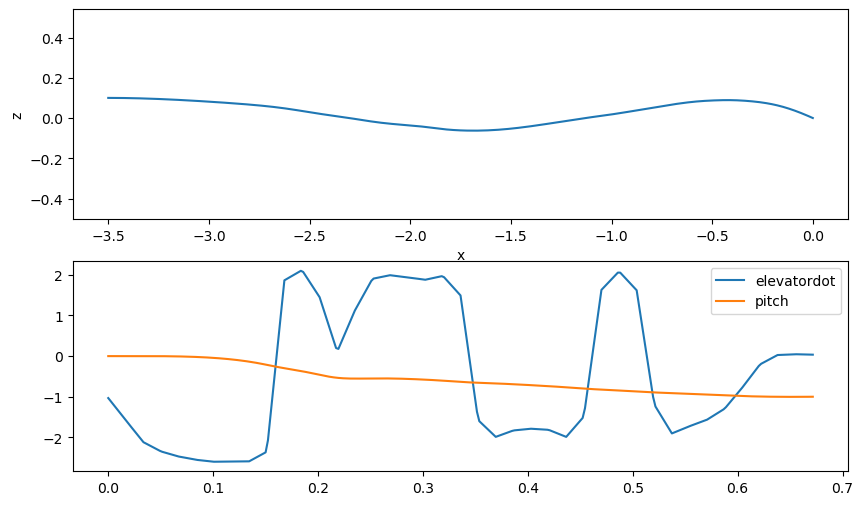

In [5]:
ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
s = GliderState(x_traj.vector_values(ts))

fig, ax = plt.subplots(2,1, figsize=(10,6))
ax[0].plot(s.x, s.z)
ax[0].set_xlabel('x')
ax[0].set_ylabel('z')
ax[0].axis('equal')
ax[1].plot(ts, u_traj.vector_values(ts).T, label='elevatordot');
ax[1].plot(ts, s.pitch, label='pitch')
ax[1].legend();

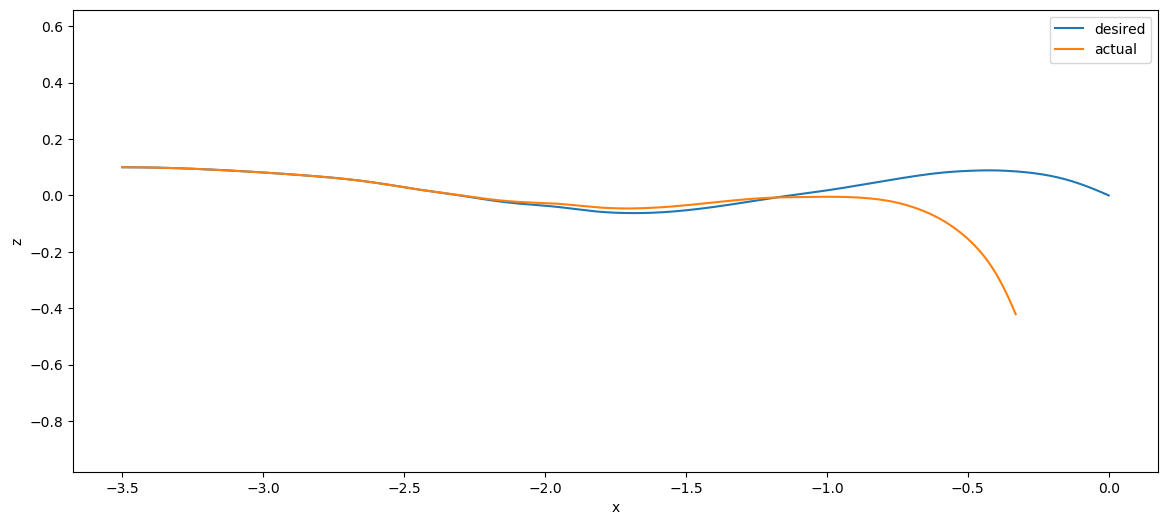

In [6]:
def open_loop_simulation(x_traj, u_traj):
    builder = DiagramBuilder()
    glider = builder.AddSystem(GliderPlant())
    scene_graph = builder.AddSystem(SceneGraph())
    GliderGeometry.AddToBuilder(builder, glider.GetOutputPort("state"),
                                scene_graph)
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph,
                                                   meshcat)
    logger = LogVectorOutput(glider.GetOutputPort("state"), builder)
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-4, xmax=1, ymin=-1, ymax=1)

    traj = builder.AddSystem(TrajectorySource(u_traj))
    builder.Connect(traj.get_output_port(), glider.get_input_port())
    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    glider_context = glider.GetMyContextFromRoot(context)

    ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
    desired_state = GliderState(x_traj.vector_values(ts))

    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(desired_state.x, desired_state.z, label='desired')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.axis('equal')

    context.SetTime(x_traj.start_time())
    initial_state = GliderState(x_traj.value(x_traj.start_time()))
    glider_context.SetContinuousState(initial_state[:])

    visualizer.StartRecording(False)
    simulator.AdvanceTo(x_traj.end_time())
    visualizer.PublishRecording()

    log = logger.FindLog(context)
    state = GliderState(log.data())
    ax.plot(state.x, state.z, label=f'actual')
    ax.legend()

open_loop_simulation(x_traj, u_traj)
    

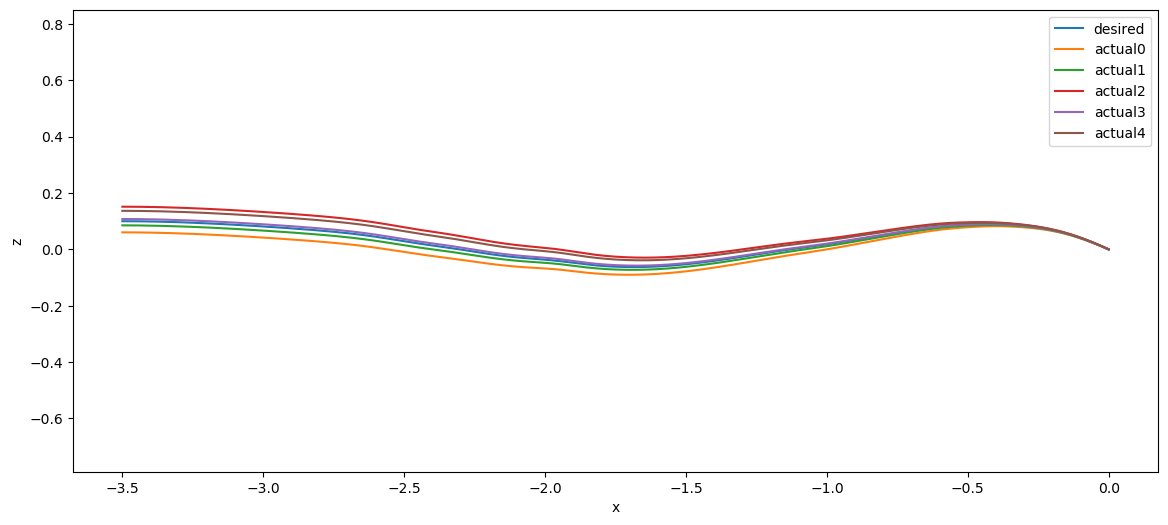

In [8]:
def finite_horizon_lqr(x_traj, u_traj):
    builder = DiagramBuilder()
    glider = builder.AddSystem(GliderPlant())
    scene_graph = builder.AddSystem(SceneGraph())
    GliderGeometry.AddToBuilder(builder, glider.GetOutputPort("state"),
                                scene_graph)
    visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph,
                                                   meshcat)
    logger = LogVectorOutput(glider.GetOutputPort("state"), builder)
    meshcat.Delete()
    meshcat.Set2dRenderMode(xmin=-4, xmax=1, ymin=-1, ymax=1)

    Q = np.diag([10, 10, 10, 1, 1, 1, 1])
    R = [0.1]
    options = FiniteHorizonLinearQuadraticRegulatorOptions()
    options.Qf = np.diag([(1 / 0.05)**2, (1 / 0.05)**2, (1 / 3.0)**2,
                          (1 / 3.0)**2, 1, 1, (1 / 3.0)**2])
    #options.use_square_root_method = True  # Pending drake PR #16812
    options.x0 = x_traj
    options.u0 = u_traj

    controller = builder.AddSystem(
        MakeFiniteHorizonLinearQuadraticRegulator(
            system=glider,
            context=glider.CreateDefaultContext(),
            t0=x_traj.start_time(),
            tf=x_traj.end_time(),
            Q=Q,
            R=R,
            options=options))
    builder.Connect(controller.get_output_port(), glider.get_input_port())
    builder.Connect(glider.GetOutputPort("state"), controller.get_input_port())

    diagram = builder.Build()

    simulator = Simulator(diagram)
    context = simulator.get_mutable_context()
    glider_context = glider.GetMyContextFromRoot(context)

    ts = np.linspace(u_traj.start_time(), u_traj.end_time(), 301)
    desired_state = GliderState(x_traj.vector_values(ts))

    fig, ax = plt.subplots(figsize=(14,6))
    ax.plot(desired_state.x, desired_state.z, label='desired')
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.axis('equal')

    rng = np.random.default_rng(123)

    for i in range(5):
        context.SetTime(x_traj.start_time())
        initial_state = GliderState(x_traj.value(x_traj.start_time()))
        initial_state.z += 0.04*rng.standard_normal()        
        glider_context.SetContinuousState(initial_state[:])

        simulator.Initialize()
        visualizer.StartRecording(False)
        simulator.AdvanceTo(x_traj.end_time())
        visualizer.PublishRecording()

        log = logger.FindLog(context)
        state = GliderState(log.data())
        log.Clear()
        ax.plot(state.x, state.z, label=f'actual{i}')
    
    ax.legend()

finite_horizon_lqr(x_traj, u_traj)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5981f1c9-7fa9-4b35-9496-bb0f15aac7ff' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>